### Imports

In [31]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor as decision_tree
from generate_features import generate_features
from datetime import timedelta
from decimal import Decimal
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read Raw Currency Data

In [18]:
exchange_rate_filenames = ["./USDEUR=X.csv", "./USDGBP=X.csv", "./USDCHF=X.csv",
                            "./EURGBP=X.csv", "./EURCHF=X.csv", "./GBPCHF=X.csv"]
currency_names = [filename.split("./")[-1].split("=")[0] for filename in exchange_rate_filenames]
raw_currency_dfs = {}
# Read and print the raw currency data
for i, filename in enumerate(exchange_rate_filenames):
    currency_name = currency_names[i]
    raw_currency_dfs[currency_name] = pd.read_csv(filename, parse_dates = ["Date"])
    print(currency_name + ": " + str(raw_currency_dfs[currency_name].shape))
    print(raw_currency_dfs[currency_name])

USDEUR: (285, 7)
          Date     Open     High       Low    Close  Adj Close  Volume
0   2022-10-03  1.02117  1.02526  1.015820  1.02117    1.02117       0
1   2022-10-04  1.01708  1.01971  1.001990  1.01708    1.01708       0
2   2022-10-05  1.00157  1.01673  1.000580  1.00157    1.00157       0
3   2022-10-06  1.00898  1.02152  1.007420  1.00898    1.00898       0
4   2022-10-07  1.02155  1.02757  1.018740  1.02155    1.02155       0
..         ...      ...      ...       ...      ...        ...     ...
280 2023-10-30  0.94675  0.94801  0.941088  0.94675    0.94675       0
281 2023-10-31  0.94206  0.94629  0.937290  0.94206    0.94206       0
282 2023-11-01  0.94526  0.95031  0.945110  0.94526    0.94526       0
283 2023-11-02  0.94455  0.94480  0.937200  0.94455    0.94455       0
284 2023-11-03  0.94170  0.94202  0.931359  0.94170    0.94170       0

[285 rows x 7 columns]
USDGBP: (285, 7)
          Date      Open     High      Low    Close  Adj Close  Volume
0   2022-10-03  0.8

### Generate Processed Features

In [20]:

extracted_features_dfs = {}
for currency_name in currency_names:
    raw_df = raw_currency_dfs[currency_name]
    extracted_features_dfs[currency_name] = generate_features(raw_df)
    print(f"{currency_name} extracted features: ")
    print(extracted_features_dfs[currency_name].head())

USDEUR extracted features: 
        Date  opt_sine_offset  opt_sine_amp  opt_sine_freq  opt_sine_phase  \
0 2023-11-03         0.007010      0.996826       0.999919       -0.000297   
1 2023-11-02         0.007023      0.996681       1.000076        0.000421   
2 2023-11-01         0.007151      1.004797       0.999876       -0.000406   
3 2023-10-31         0.006120      1.000000       1.000519       -0.004140   
4 2023-10-30         0.005140      1.000000       0.999855        0.002468   

   opt_fourier_offset  opt_fourier_cosamp  opt_fourier_cosfreq  \
0            0.007833           -0.292296             0.939772   
1            0.007767           -0.229243             0.994061   
2            0.007458            0.707380             0.964368   
3            0.007163            0.094613             1.143449   
4            0.006923            0.090683             1.096072   

   opt_fourier_cosphase  opt_fourier_sinamp  ...        ROC5      ROC20  \
0              1.027652        

C:\Users\danne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\_minpack_py.py:492: RuntimeWarning: Number of calls to function has reached maxfev = 1600.
  warnings.warn(errors[info][0], RuntimeWarning)


USDGBP extracted features: 
        Date  opt_sine_offset  opt_sine_amp  opt_sine_freq  opt_sine_phase  \
0 2023-11-03         0.006686      1.000000       0.999889       -0.000276   
1 2023-11-02         0.007367      1.000000       0.999851        0.001898   
2 2023-11-01         0.007742      1.000000       1.000006       -0.001609   
3 2023-10-31         0.006334      1.010275       1.000527       -0.003510   
4 2023-10-30         0.005462      1.000000       0.999801        0.001999   

   opt_fourier_offset  opt_fourier_cosamp  opt_fourier_cosfreq  \
0            0.004528           -0.208289             0.808304   
1            0.004295           -0.235218             0.971241   
2            0.003805            0.426919             0.733819   
3            0.003253            0.131591             1.243146   
4            0.002681            0.394487             1.078280   

   opt_fourier_cosphase  opt_fourier_sinamp  ...         ROC5       ROC20  \
0              1.358472      

### Training/Testing Set Creation

In [21]:
def individ_train_test_splits(df, num_days):
    df2 = df.copy(deep=False)
    X_test = df2.iloc[:5]
    X_test.set_index('Date', inplace=True)
    X_test = X_test.drop(columns=['t', 'Close'])
    y = df2[['Date', 'Close']]
    y.index = y['Date']
    y = y.drop(columns=['Date'])
    y = y.shift(periods=5).dropna()
    y.reset_index(inplace=True)
    df2 = df2.merge(y, how='inner', on='Date')
    df2 = df2.drop(columns=['Close_x'])
    df2.set_index('Date', inplace=True)
    X_train, X_val = df2[df2['t'] < df2['t'].max()-num_days], df2[df2['t'] >= df2['t'].max()-num_days]
    X_train = X_train.drop(columns=['t','Close_y'])
    X_val = X_val.drop(columns=['t','Close_y'])
    y_train, y_val = df2[df2['t'] < df2['t'].max()-num_days]['Close_y'], df2[df2['t'] >= df2['t'].max()-num_days]['Close_y']
    
    return [X_train, X_val, y_train, y_val, X_test]

In [22]:
def feature_selection(df):
    X = df.drop(columns=['Date', 't', 'Close'])
    bad_features = []
    for col in list(X.columns):
        r = np.corrcoef(X[col],df['Close'])

        if r[0,1] < 0.5:
            bad_features.append(col)
    
    return bad_features

In [25]:
reduced_feature_dfs = {}
for currency_name in currency_names:
    feature_df = extracted_features_dfs[currency_name]
    reduced_feature_dfs[currency_name] = feature_df.drop(columns=feature_selection(feature_df))

In [28]:
print(currency_names)
USD_EUR_datasets = individ_train_test_splits(reduced_feature_dfs['USDEUR'], 14)
USD_GBP_datasets = individ_train_test_splits(reduced_feature_dfs['USDGBP'], 14)
USD_CHF_datasets = individ_train_test_splits(reduced_feature_dfs['USDCHF'], 14)

EUR_GBP_datasets = individ_train_test_splits(reduced_feature_dfs['EURGBP'], 14)
EUR_CHF_datasets = individ_train_test_splits(reduced_feature_dfs['EURCHF'], 14)
GBP_CHF_datasets = individ_train_test_splits(reduced_feature_dfs['GBPCHF'], 14)

['USDEUR', 'USDGBP', 'USDCHF', 'EURGBP', 'EURCHF', 'GBPCHF']


In [114]:
def tree_forecast(X_train, y_train, X_val, y_val, X_test, forex_name):
    mdl = decision_tree(criterion='friedman_mse', splitter='random',
                        min_samples_split=4, max_depth=12)
    mdl.fit(X_train, y_train)
    y_train2 = pd.DataFrame(y_train.copy())
    y_train2.reset_index(inplace=True)
    y_train2['pred'] = mdl.predict(X_train)
    train_MSE = np.sum((y_train2['pred']-y_train2['Close_y'])**2)

    y_val2 = pd.DataFrame(y_val.copy())
    y_val2.reset_index(inplace=True)
    y_val2['pred'] = mdl.predict(X_val)
    test_MSE = np.sum((y_val2['pred']-y_val2['Close_y'])**2)

    plt.figure()
    plt.plot(y_train2['Date']+timedelta(days=7), y_train2['pred'], label='Prediction')
    plt.plot(y_train2['Date']+timedelta(days=7), y_train2['Close_y'], label='Close')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Close')
    plt.legend()
    plt.title(f'Training Set Predictions for {forex_name} Exchange Rate, MSE = %.4E' % Decimal(train_MSE))

    plt.figure()
    plt.plot(y_val2['Date']+timedelta(days=7), y_val2['pred'], label='Prediction')
    plt.plot(y_val2['Date']+timedelta(days=7), y_val2['Close_y'], label='Close')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Close')
    plt.legend()
    plt.title(f'Test Set Predictions for {forex_name} Exchange Rate, MSE = %.4E' % Decimal(test_MSE))

    
    forecast_vals = pd.DataFrame({'Date': X_test.index+timedelta(days=7), f'Predicted_Close_{forex_name}':mdl.predict(X_test)})
    return forecast_vals

#### USD-EURO Forecast

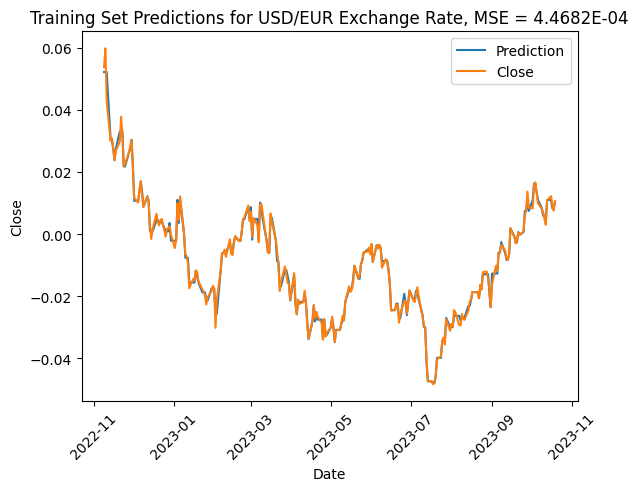

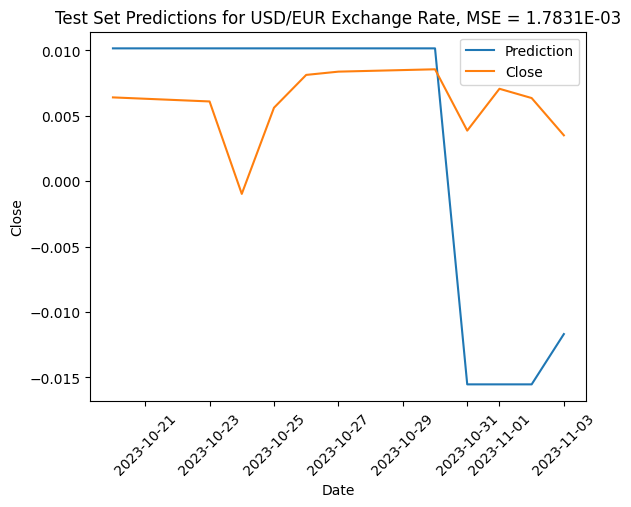

In [113]:
usd_eur_forecast_vals = tree_forecast(USD_EUR_datasets[0],USD_EUR_datasets[2], USD_EUR_datasets[1], USD_EUR_datasets[3], USD_EUR_datasets[4], "USD/EUR")

#### USD-GBP Forecast

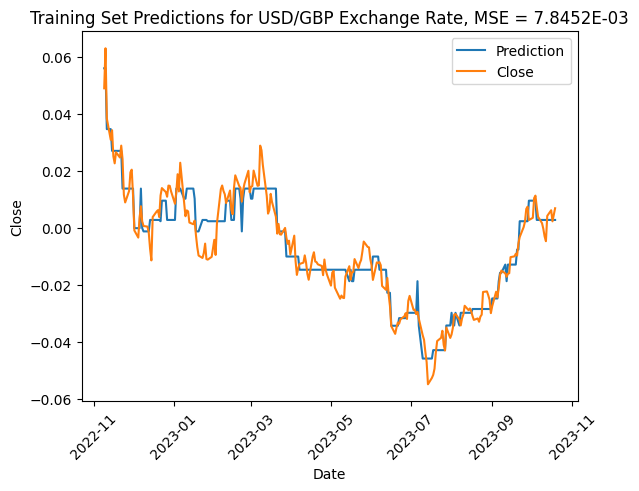

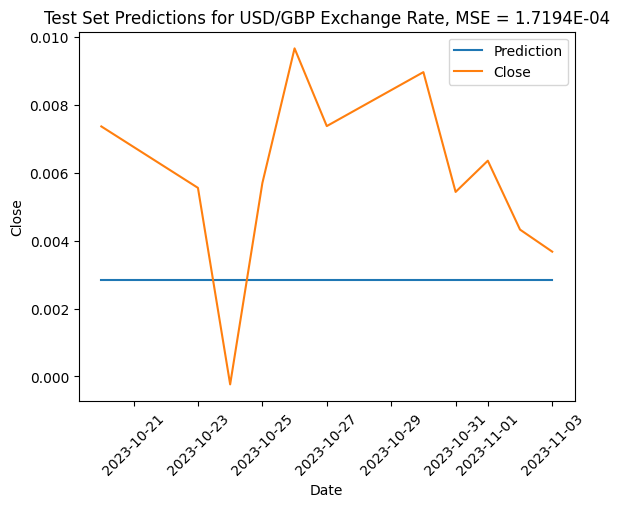

In [103]:
usd_GBP_forecast_vals = tree_forecast(USD_GBP_datasets[0],USD_GBP_datasets[2], USD_GBP_datasets[1], USD_GBP_datasets[3], USD_GBP_datasets[4], "USD/GBP")

#### USD-CHF Forecast

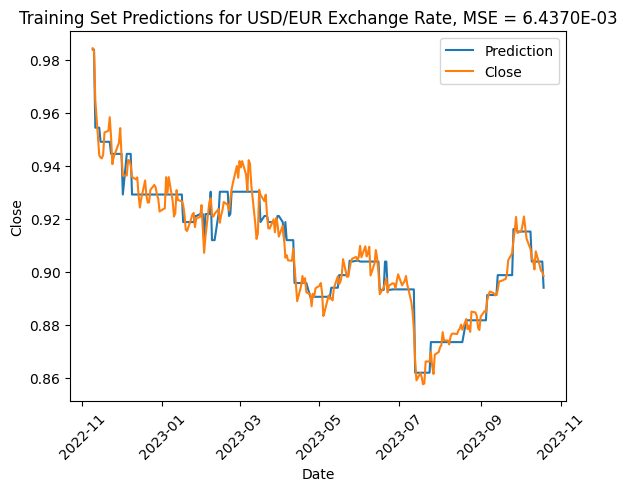

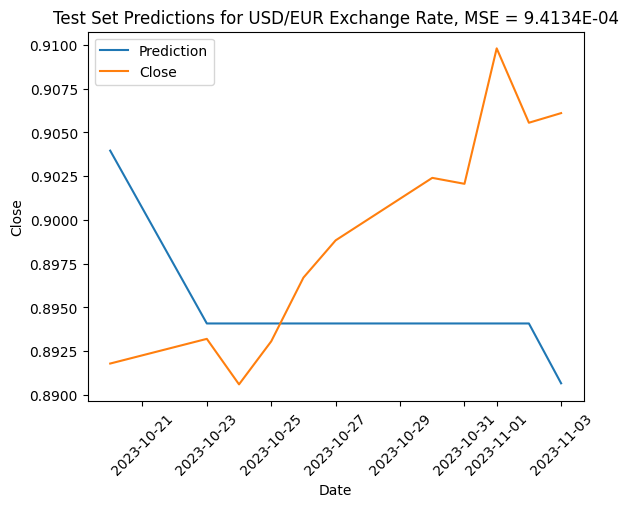

In [104]:
usd_chf_forecast_vals = tree_forecast(USD_CHF_datasets[0],USD_CHF_datasets[2], USD_CHF_datasets[1], USD_CHF_datasets[3], USD_CHF_datasets[4], "USD/EUR")

#### EURO-GBP Forecast

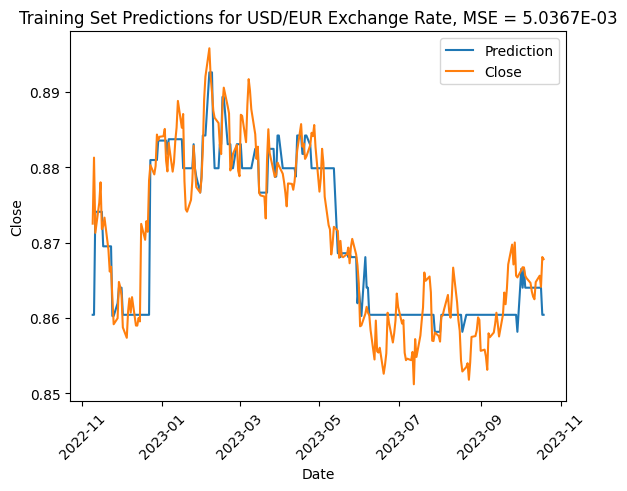

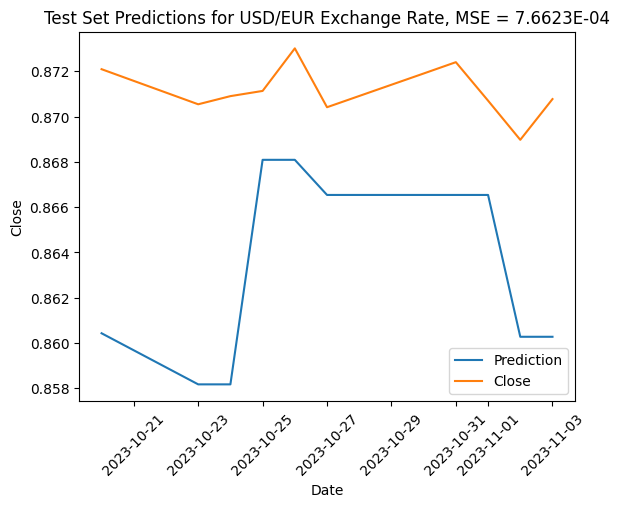

In [105]:
EUR_GBP_forecast_vals = tree_forecast(EUR_GBP_datasets[0],EUR_GBP_datasets[2], EUR_GBP_datasets[1], EUR_GBP_datasets[3], EUR_GBP_datasets[4], "USD/EUR")

#### EURO-CHF Forecast

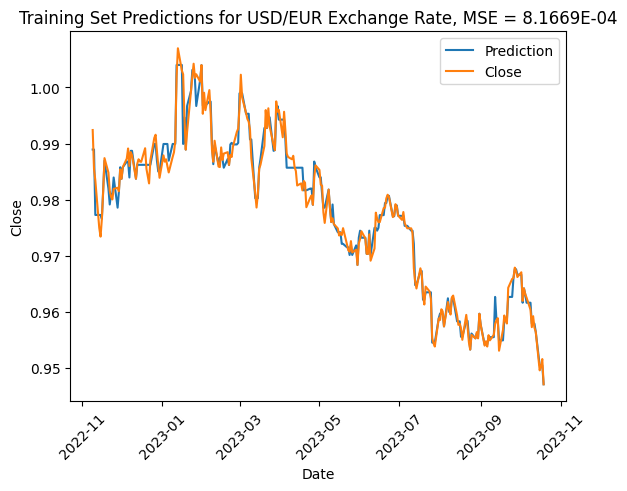

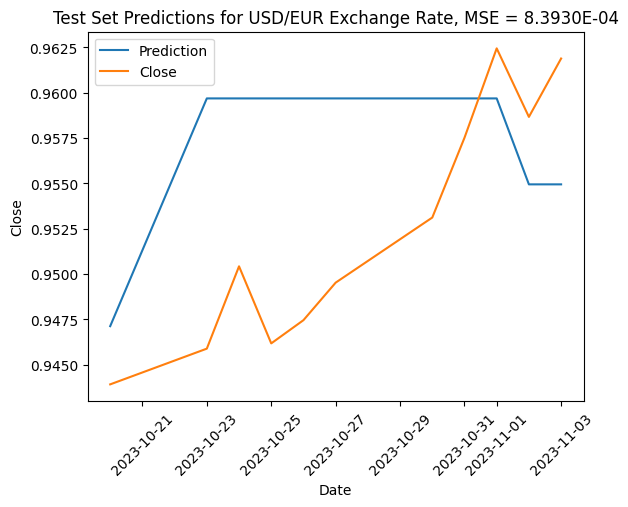

In [68]:
EUR_CHF_forecast_vals = tree_forecast(EUR_CHF_datasets[0],EUR_CHF_datasets[2], EUR_CHF_datasets[1], EUR_CHF_datasets[3], EUR_CHF_datasets[4], "USD/EUR")

#### GBP-CHF Forecast

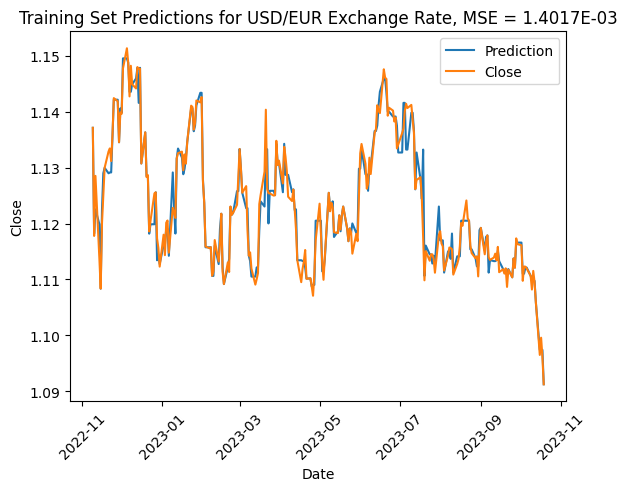

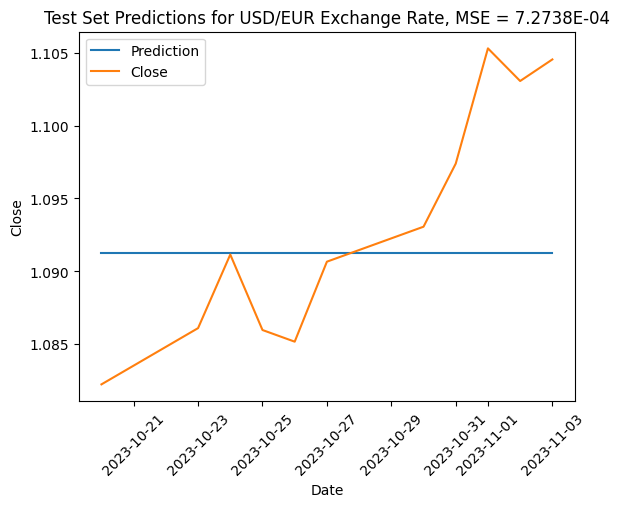

In [69]:
GBP_CHF_forecast_vals = tree_forecast(GBP_CHF_datasets[0],GBP_CHF_datasets[2], GBP_CHF_datasets[1], GBP_CHF_datasets[3], GBP_CHF_datasets[4], "USD/EUR")